# Create a simple linear regression model to predict the number of wins for an NFL team.

In [50]:
import pandas as pd

data = pd.read_csv("data/model_data.csv")
data.columns

Index(['year', 'wins', 'losses', 'win_loss_perc', 'points', 'points_opp',
       'points_diff', 'mov', 'g', 'total_yards', 'plays_offense',
       'yds_per_play_offense', 'turnovers', 'fumbles_lost', 'first_down',
       'pass_cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int',
       'pass_net_yds_per_att', 'pass_fd', 'rush_att', 'rush_yds', 'rush_td',
       'rush_yds_per_att', 'rush_fd', 'penalties', 'penalties_yds', 'pen_fd',
       'score_pct', 'turnover_pct', 'exp_pts_tot', 'ties', 'team_encoded'],
      dtype='object')

### Standardize and split the data.

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

drop = [
    'wins', 'losses', 'win_loss_perc', 'ties'
]

x = data.drop(columns=drop)
y = data['wins']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

### Create a baseline model with no hyperparameter tuning.

In [52]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error as mse

mse(y_test, y_pred)

1.5392843050244538

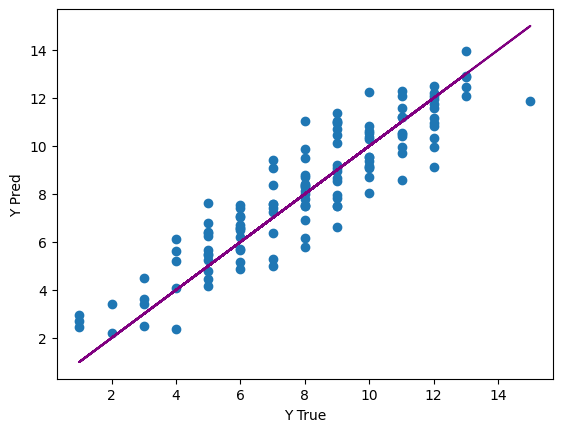

In [53]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Y True")
plt.ylabel("Y Pred")

plt.plot(y_test, y_test, color='purple')
plt.show()

### Clearly this model is not the best in terms of predicting wins. An average of 1.5 games off for a 16 or 17 game season is not a good enough performance.

## Hyperparameter Tuning

In [54]:
model.feature_names_in_

array(['year', 'points', 'points_opp', 'points_diff', 'mov', 'g',
       'total_yards', 'plays_offense', 'yds_per_play_offense',
       'turnovers', 'fumbles_lost', 'first_down', 'pass_cmp', 'pass_att',
       'pass_yds', 'pass_td', 'pass_int', 'pass_net_yds_per_att',
       'pass_fd', 'rush_att', 'rush_yds', 'rush_td', 'rush_yds_per_att',
       'rush_fd', 'penalties', 'penalties_yds', 'pen_fd', 'score_pct',
       'turnover_pct', 'exp_pts_tot', 'team_encoded'], dtype=object)

['points' 'points_opp' 'points_diff' 'mov' 'total_yards' 'plays_offense'
 'yds_per_play_offense' 'turnovers' 'fumbles_lost' 'first_down' 'pass_cmp'
 'pass_yds' 'pass_td' 'pass_int' 'pass_net_yds_per_att' 'pass_fd'
 'rush_att' 'rush_yds' 'rush_td' 'rush_yds_per_att' 'rush_fd' 'penalties'
 'pen_fd' 'score_pct' 'turnover_pct' 'exp_pts_tot']


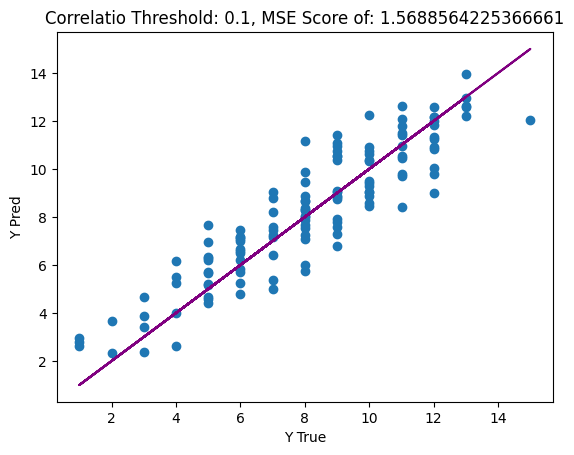

['points' 'points_opp' 'points_diff' 'mov' 'total_yards' 'plays_offense'
 'yds_per_play_offense' 'turnovers' 'fumbles_lost' 'first_down' 'pass_yds'
 'pass_td' 'pass_int' 'pass_net_yds_per_att' 'pass_fd' 'rush_att'
 'rush_yds' 'rush_td' 'rush_fd' 'score_pct' 'turnover_pct' 'exp_pts_tot']


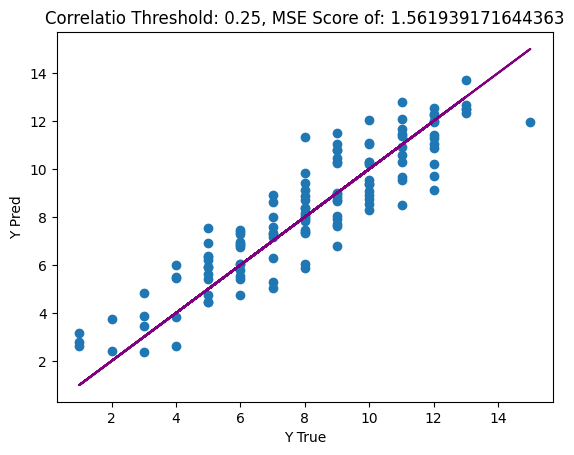

['points' 'points_opp' 'points_diff' 'mov' 'total_yards'
 'yds_per_play_offense' 'first_down' 'pass_td' 'pass_net_yds_per_att'
 'score_pct' 'turnover_pct' 'exp_pts_tot']


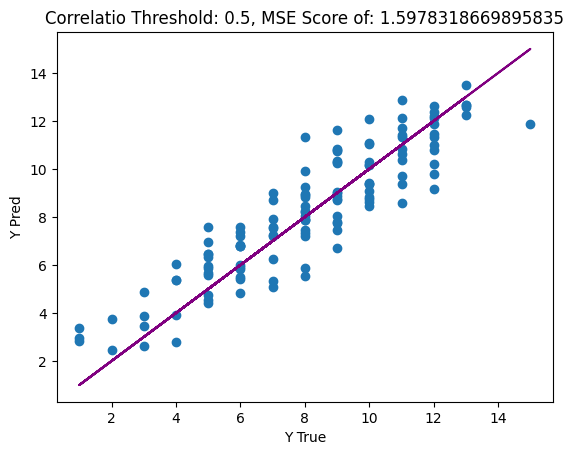

['points_diff' 'mov']


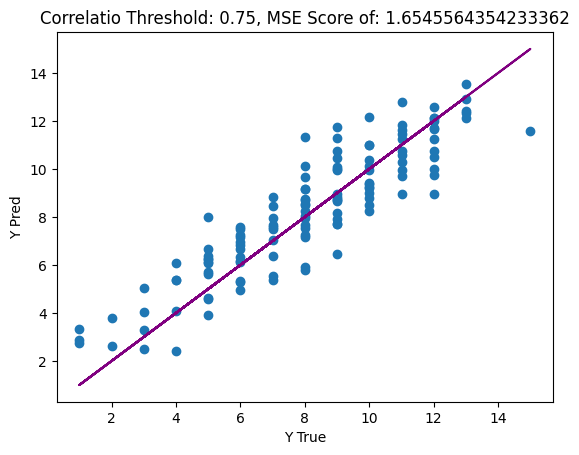

In [55]:
# Let's limit the number of features that we see to those only with a given threshold of correlation
corr = data.drop(columns=drop).corrwith(data['wins'])

scores = []

thresholds = [0.1, 0.25, 0.5, 0.75]
for thresh in thresholds:
    features = [feature for feature in corr.index if abs(corr[feature]) >= thresh]
    x = data.drop(columns=drop)[features]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(model.feature_names_in_)

    plt.scatter(y_test, y_pred)
    plt.xlabel("Y True")
    plt.ylabel("Y Pred")
    plt.title(f"Correlatio Threshold: {thresh}, MSE Score of: {mse(y_test, y_pred)}")

    plt.plot(y_test, y_test, color='purple')
    plt.show()


### While this model is not perfect, let's compare it to Vegas's win loss projection of each team for each season.

In [62]:
import requests
from bs4 import BeautifulSoup

vegas_data = []

for year in data['year'].unique():
        
    url = f'https://www.pro-football-reference.com/years/{year}/preseason_odds.htm'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('table', {'id': 'preseason_odds'})

    headers = [th.text for th in table.find('tr').find_all('th')]
    headers.append('year')

    # Extract data
    for row in table.find_all('tr')[1:]:  # Skip header row
        my_row = []
        # Find the team name column
        team_name = row.find('a').text
        my_row.append(team_name)
        cols = row.find_all('td')
        if cols:  # Avoid empty rows
            my_row.extend([col.text for col in cols])
        my_row.append(year)
        vegas_data.append(my_row)

# Create DataFrame
vegas_df = pd.DataFrame(vegas_data, columns=headers)


In [65]:
vegas_df['wins'] = vegas_df['Record'].apply(lambda x: x.split('-')[0])
vegas_df

,Tm,Super Bowl Odds,W/L O-U,Record,year,wins
0,Arizona Cardinals,+30000,5.0,4-12 (under),2003,4
1,Atlanta Falcons,+1200,9.5,5-11 (under),2003,5
2,Baltimore Ravens,+3500,7.5,10-6 (over),2003,10
3,Buffalo Bills,+2000,8.5,6-10 (under),2003,6
4,Carolina Panthers,+6000,7.5,11-5 (over),2003,11
...,...,...,...,...,...,...
667,San Francisco 49ers,+1000,10.5,12-5 (over),2023,12
668,Seattle Seahawks,+3500,8.5,9-8 (over),2023,9
669,Tampa Bay Buccaneers,+10000,6.5,9-8 (over),2023,9
670,Tennessee Titans,+9000,7.5,6-11 (under),2023,6


In [73]:
import numpy as np

vegas_df['wins'] = pd.to_numeric(vegas_df['wins'], errors='coerce')
vegas_df['W/L O-U'] = pd.to_numeric(vegas_df['W/L O-U'], errors='coerce')

mse(vegas_df['wins'], vegas_df['W/L O-U'])

7.295758928571429

## Analysis